In [14]:
import os, sys, glob
import math
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)  
sns.set_style('whitegrid')
mpl.rc('text', usetex=True)
sns.set_context("notebook", font_scale=1.2)

In [15]:
# Set the input folder for TRACERx 
tx_folder = "./TRACERx_lung/"

# Set the input folder for Razavi
rz_folder = "./breast_Razavi/"

# Model Selection

In [16]:
# Import results file

def ms_import_file(resultsFile):
    with open(resultsFile, "r") as inf:
        pairs = []
        first_line = inf.readline().split()
        k_col = first_line.index("inferred_k")
        dist_col = first_line.index("PC_dist")
        for line in inf:
            k = int(line.split()[k_col])
            dist = float(line.split()[dist_col])
            if k <= 15:
                pairs.append((k, dist))
    return pairs

In [17]:
# Smooth distances so that they are monotonically decreasing

def ms_smooth(pairs):
    smooth_pairs = []
    pairs.sort(key=lambda elem: elem[0])
    low_d = pairs[0][1]
    for k,d in pairs:
        low_d = min(low_d, d)
        smooth_pairs.append((k,low_d))

    return smooth_pairs

In [18]:
# Sweeping from right to left, find the first k with significant improvement over k-1

def ms_find_k(pairs, p_threshold, a_threshold):
    pairs.sort(key=lambda elem: elem[0], reverse=True)
    prev_d = pairs[0][1]
    for k,d in pairs[1:]:
        a_change = d-prev_d
        p_change = a_change/(prev_d*1.0)
        if (p_change >= p_threshold) and (a_change >= a_threshold):
            return k+1
        prev_d = d

In [19]:
# Set absolute and relative thresholds
pt = .05
at = .5

In [20]:
# Run model selection for TRACERx
f = tx_folder+"results.tsv"
pl = ms_smooth(ms_import_file(f))
chosen_k_tx = ms_find_k(pl, pt, at)
print chosen_k_tx

10


In [21]:
# Run model selection for Razavi
f = rz_folder+"results.tsv"
pl = ms_smooth(ms_import_file(f))
chosen_k_rz = ms_find_k(pl, pt, at)
print chosen_k_rz

8


# Model Selection Plots

In [22]:
# Create function for reading in result summary files
# It returns a list of pairs, a pair for each cluster
# The first item is the normalized cost of that cluster
# The second item is the number of trees

# We sort by the cost from increasing to decreasing
def read_count_score(f, total_k):
    
    pairs = []
    
    with open(f, 'r') as inf:
        first_line = inf.readline().split()
        k_col = first_line.index("k")
        
        second_line = inf.readline().split()
        k = int(second_line[k_col])
        for i in range(0, total_k):
        
            if i < k:
                cost_col = first_line.index("cost-%s" % str(i))
                tree_col = first_line.index("trees-%s" % str(i))
            
                cost = float(second_line[cost_col])
                tree = int(second_line[tree_col])
            else:
                cost = 0
                tree = 0
            
            pairs.append((cost, tree))
                    
                
    return sorted(pairs, key=lambda x: x[1], reverse=True)

In [23]:
# Define a function for plotting the cost of each cluster
def plot_cost(pd, ax, chosen_k):

    
    # Extract number of clusters
    r = range(len(pd[1]))
    labels = [x+1 for x in r]

    # Extract total number of trees
    n = sum([x[1] for x in pairs_dict[1]])
    totals = [n for s in labels]
 
    # Set color palette of bars
    #cols = sns.color_palette("Set2", 8)
    #if len(labels) > 8:
    cols = sns.color_palette("Paired") + sns.color_palette("Set2", 8) 

    # Create a plot for each bar
    barWidth = 0.55
    bottoms = [ 0 for i in r ]
    b = []
    for i in r:
        
        bars = []
        for k in r:
            bars.append(pd[k+1][i][0])
        
        b.append(plt.bar(labels, bars, bottom=bottoms, color=cols[i], width=barWidth, axes=ax))
        bottoms = [i+j for i,j in zip(bottoms, bars)]

    ax.legend(b, labels, loc="upper right", ncol=5, title="cluster")
    ax.set_xticks(r, labels)
    ax.set_ylabel("norm.~distance per cluster")
    #ax.set_ylim((0,1))
    ax.grid(axis="x", b=False)
    ax.set_xlim((0.5,labels[-1] + 0.5))
    
    for i in range(len(ax.patches)):
        
        if i == chosen_k-1:
            # get_x pulls left or right; get_height pushes up or down
            ax.text(ax.patches[i].get_x()+.15, bottoms[i]+0.3, "*", fontsize=20)
            

In [24]:
# Note change y axis and add new color palette
# Define a function for plotting the number of trees
def plot_nr_trees(pd, ax, yaxis):

    # Extract number of clusters
    r = range(len(pd[1]))
    labels = [x+1 for x in r]
    
    # Extract total number of trees
    n = sum([x[1] for x in pairs_dict[1]])
    totals = [n for s in labels]
    
    # Set color palette of bars
    #cols = sns.color_palette("Set2", 8)
    #if len(labels) > 8:
    #    cols = cols + [cols[-1]] * (len(labels) - 8)
    cols = sns.color_palette("Paired") + sns.color_palette("Set2", 8)
    
    # Create a plot for each bar
    barWidth = 0.55
    bottoms = [ 0 for i in r ]
    b = []
    for i in r:
        
        bars = []
        for k in r:
            bars.append(pd[k+1][i][1])
            
        b.append(plt.bar(labels, bars, bottom=bottoms, color=cols[i], width=barWidth, axes=ax))
        bottoms = [i+j for i,j in zip(bottoms, bars)]

    # Set plot attributes
    ax.set_xticks(r, labels)
    ax.set_ylabel("\#trees per cluster")
    ax.grid(axis="x", b=False)
    ax.set_xlabel("\#clusters $k$")
    ax.set_xlim((0.5,labels[-1] + 0.5))
    ax.set_ylim((-0.5, yaxis))

In [25]:
# Set the maximum k used in this study
k = 15

# Read in result summary files
# Store result in dictionary for each k
pairs_dict = {}
for i in range(1, k+1):
    in_file = tx_folder+"k%s_summary.tsv" % str(i)
    pairs_dict[i] = read_count_score(in_file, k)

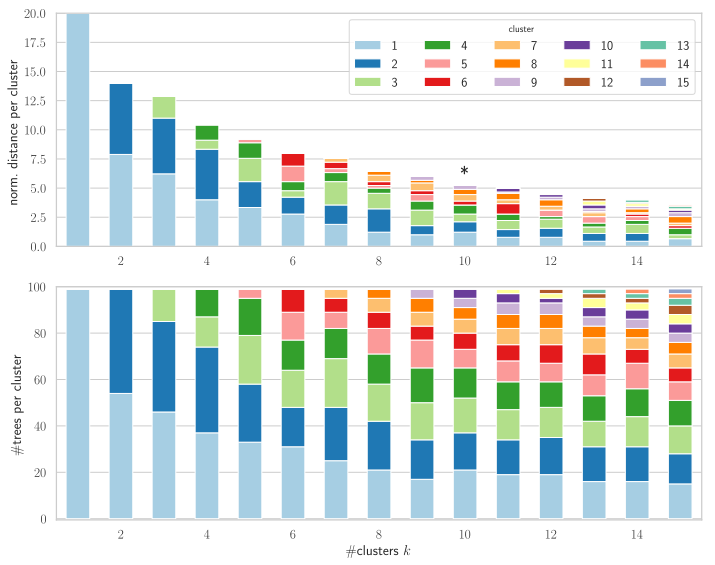

In [26]:
# Run plotting code

nrRows = 2
nrCols = 1
idx = 1

ax = plt.subplot(nrRows, nrCols, idx)
plot_cost(pairs_dict, ax, chosen_k_tx)
idx += 1
ax = plt.subplot(nrRows, nrCols, idx)
plot_nr_trees(pairs_dict, ax, 100)

plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.savefig("tx_model_selection.pdf")

In [27]:
# Set the maximum k used in this study
k = 15

# Read in result summary files
# Store result in dictionary for each k
pairs_dict = {}
for i in range(1, k+1):
    in_file = rz_folder+"k%s_r1000_c100_summary.tsv" % str(i)
    pairs_dict[i] = read_count_score(in_file, k)

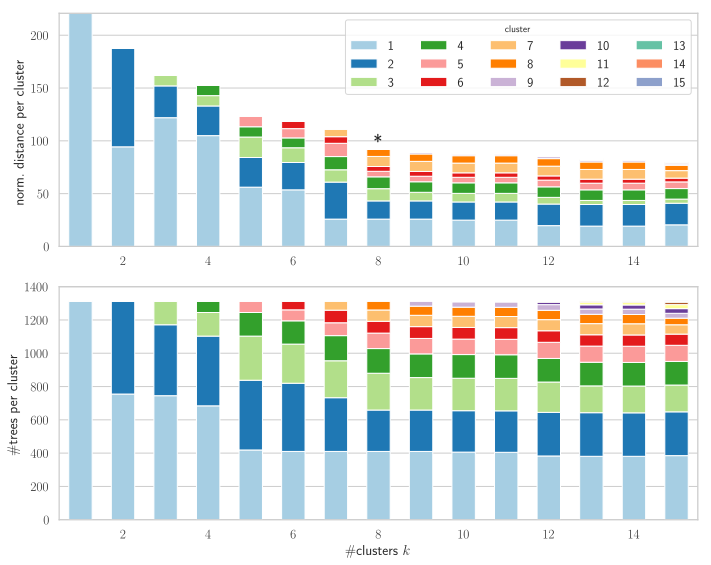

In [28]:
# Run plotting code

nrRows = 2
nrCols = 1
idx = 1

ax = plt.subplot(nrRows, nrCols, idx)
plot_cost(pairs_dict, ax, chosen_k_rz)
idx += 1
ax = plt.subplot(nrRows, nrCols, idx)
plot_nr_trees(pairs_dict, ax, 1400)

plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.savefig("rv_model_selection.pdf")